In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import mysql.connector

db = mysql.connector.connect(host="localhost",
                            username="root",
                            password="qwerty@786",
                            database="ecommerce")
cur = db.cursor()

# All the unique cities where customers are located

In [3]:
query = """select distinct customer_city from customers"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()


,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Number of orders placed in 2017

In [5]:
query = """
select count(order_id) 
from orders 
where year(order_purchase_timestamp) = 2017"""

cur.execute(query)
data = cur.fetchall()
data[0][0]

45101

# Total sales per category.

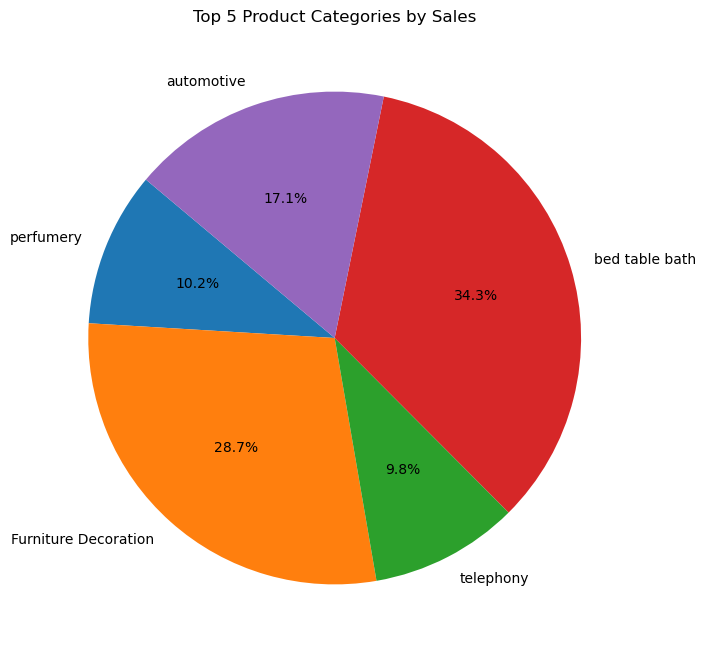

In [35]:
query = """
select products.product_category as Category,
round(sum(payments.payment_value)) as Sales 
From products 
join order_items
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by Category
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Category","Sales"])
plt.figure(figsize=(8, 8))
plt.pie(df['Sales'][:5], labels=df['Category'][:5],autopct='%1.1f%%', startangle=140)
plt.title('Top 5 Product Categories by Sales')
plt.show()



In [8]:
query = """select 
sum(case when payment_installments >= 1 
then 1 else 0 end)/count(*)*100 from payments"""

cur.execute(query)
data = cur.fetchall()
data[0][0]

Decimal('99.9981')

# 99% Of customer uses pay in installment type

# Number of customers from each state. 

Text(0.5, 1.0, 'Count of Customers From each state')

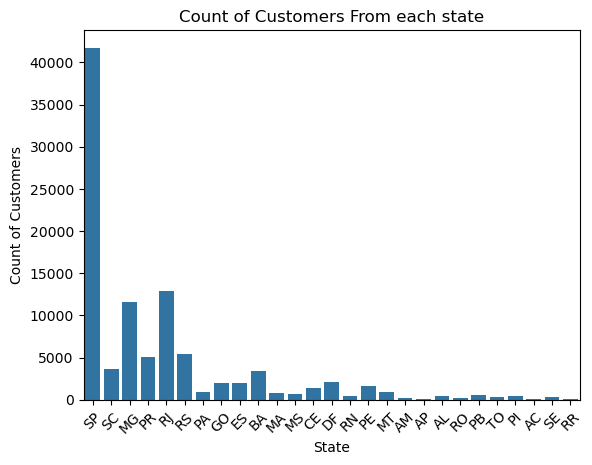

In [11]:
query = """select customer_state,
count(customer_id) 
from customers
group by customer_state"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["State","Count of Customers"])

sns.barplot(x="State",y="Count of Customers",data=df)
plt.xticks(rotation=45)
plt.title(label="Count of Customers From each state")

# Number of orders per month in 2018.

Text(0.5, 1.0, 'Number Of Orders Per Month in 2018')

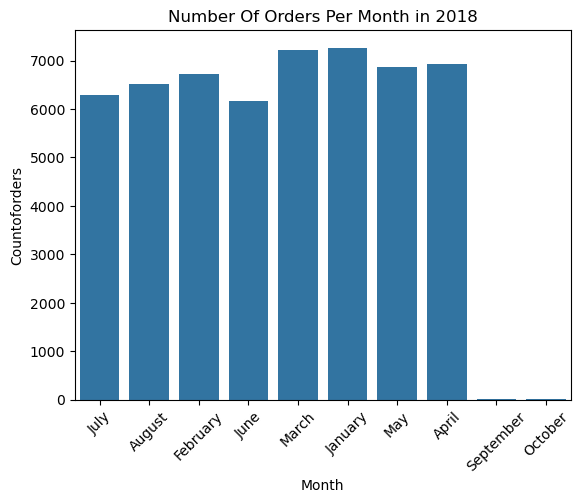

In [13]:
query = """select monthname(order_purchase_timestamp) as Month,
count(order_id) as Countoforders 
from orders 
where year(order_purchase_timestamp) = 2018
group by Month"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Month","Countoforders"])
sns.barplot(x="Month",y="Countoforders",data=df)
plt.xticks(rotation=45)
plt.title(label="Number Of Orders Per Month in 2018")

# Total revenue generated by each seller, and rank them by revenue.

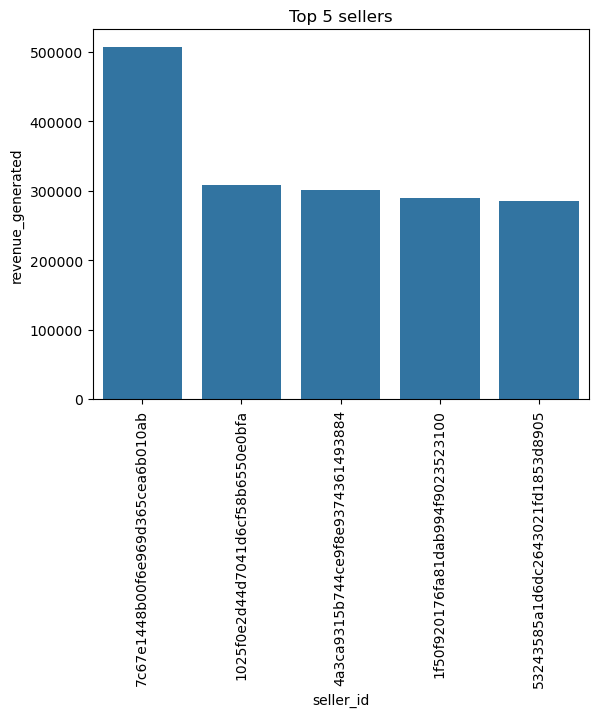

In [39]:
query = """ select * , 
dense_rank() over(order by revenue desc) as rn 
from
(select order_items.seller_id , round(sum(payments.payment_value)) as revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["seller_id","revenue_generated","rank"])
sns.barplot(x='seller_id',y='revenue_generated',data= df[:5])
plt.xticks(rotation=90)
plt.title(label= "Top 5 sellers")
plt.show()

# year over year Sales And Growth rate of total sales

In [17]:
query = """select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders 
join payments
on orders.order_id = payments.order_id
group by years 
order by years

"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ["years","sales"])
df



,years,sales
0,2016,59362.34
1,2017,7249746.73
2,2018,8699763.05


In [18]:
query = """ with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment 
from orders 
join payments
on orders.order_id = payments.order_id
group by years
order by years)
select years,
((payment - lag(payment,1) over(order by years))/lag(payment,1) over(order by years))*100 
from a
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ["years","YOY Growth in %"])
df


,years,YOY Growth in %
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


 # Identifying the top 3 customers who spent the most money in each year

In [20]:
query = """ select years,
customer,
payment,d_rank 
from
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id as customer,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) as d_rank
from orders 
join payments 
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp) ,
orders.customer_id) as a
where d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ["years","customer_id","payments","rank"])
df


,years,customer_id,payments,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


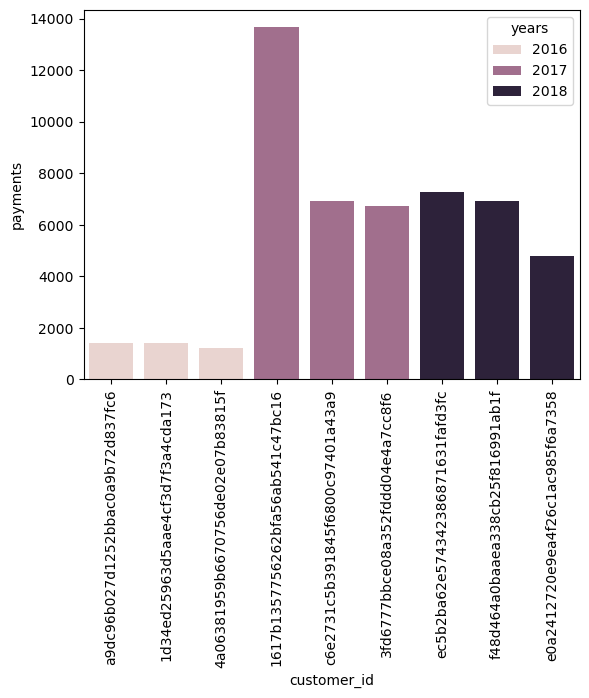

In [21]:
query = """ select years,customer,payment,d_rank from
(select year(orders.order_purchase_timestamp) as years,
orders.customer_id as customer,
sum(payments.payment_value) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)order by sum(payments.payment_value) desc) as d_rank
from orders join payments 
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp) ,orders.customer_id) as a
where d_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns= ["years","customer_id","payments","rank"])
sns.barplot(x="customer_id",y="payments",hue="years",data=df)
plt.xticks(rotation=90)
plt.show()